In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics, losses
from keras.datasets import mnist

/home/bastien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Let's build the simplest possible autoencoder

In [3]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [7]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 4s 0us/step


In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [10]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.3600 - val_loss: 0.2710
Epoch 2/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.2640 - val_loss: 0.2531
Epoch 3/50
60000/60000 [==============================] - 5s 87us/step - loss: 0.2430 - val_loss: 0.2308
Epoch 4/50
60000/60000 [==============================] - 5s 86us/step - loss: 0.2234 - val_loss: 0.2138
Epoch 5/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.2085 - val_loss: 0.2006
Epoch 6/50
60000/60000 [==============================] - 5s 88us/step - loss: 0.1969 - val_loss: 0.1906
Epoch 7/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.1881 - val_loss: 0.1828
Epoch 8/50
60000/60000 [==============================] - 6s 92us/step - loss: 0.1810 - val_loss: 0.1763
Epoch 9/50
60000/60000 [==============================] - 6s 93us/step - loss: 0.1749 - val_loss: 0.1707
Epoc

In [12]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

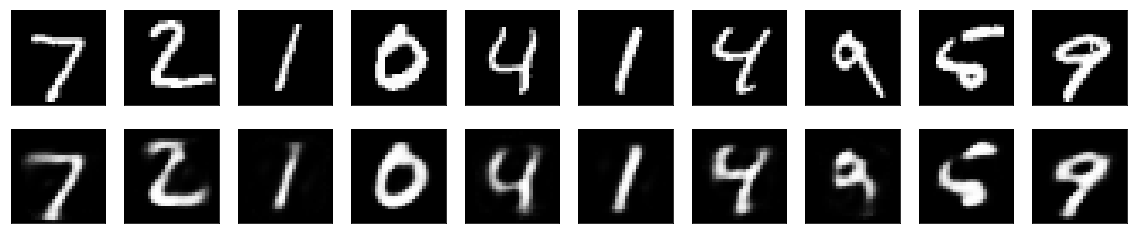

In [13]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
W = encoder.layers[-1].get_weights()

In [24]:
W[0].shape

(784, 32)

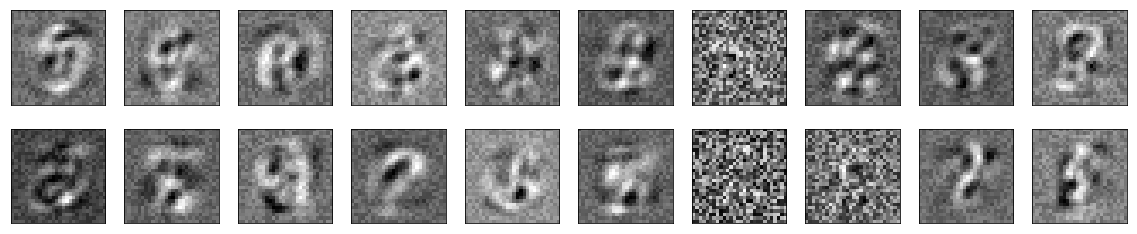

In [25]:
n = 10  # how many basis images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(W[0][:,i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(W[0][:,n+i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Adding a sparsity constraint on the encoded representations

In [59]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)



# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [71]:
Wenc = encoder.layers[1].get_weights()

In [72]:
len(Wenc)

2

In [73]:
Wenc[0].shape

(784, 32)

In [69]:
autoencoder.layers

In [75]:
Wae = autoencoder.layers[1].get_weights()

In [77]:
Wae[0].shape

(784, 32)

In [60]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 101us/step - loss: 0.6729 - val_loss: 0.6484
Epoch 2/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.4531 - val_loss: 0

Epoch 77/100
60000/60000 [==============================] - 5s 89us/step - loss: 0.2828 - val_loss: 0.2826
Epoch 78/100
60000/60000 [==============================] - 5s 89us/step - loss: 0.2825 - val_loss: 0.2823
Epoch 79/100
60000/60000 [==============================] - 5s 89us/step - loss: 0.2822 - val_loss: 0.2820
Epoch 80/100
60000/60000 [==============================] - 5s 89us/step - loss: 0.2819 - val_loss: 0.2817
Epoch 81/100
60000/60000 [==============================] - 5s 88us/step - loss: 0.2816 - val_loss: 0.2814
Epoch 82/100
60000/60000 [==============================] - 5s 89us/step - loss: 0.2813 - val_loss: 0.2812
Epoch 83/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.2810 - val_loss: 0.2809
Epoch 84/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.2808 - val_loss: 0.2806
Epoch 85/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.2805 - val_loss: 0.2804
Epoch 86/100
60000/60000 [===========

In [61]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [62]:
decoded_imgs.shape

(10000, 784)

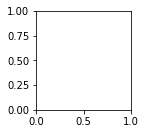

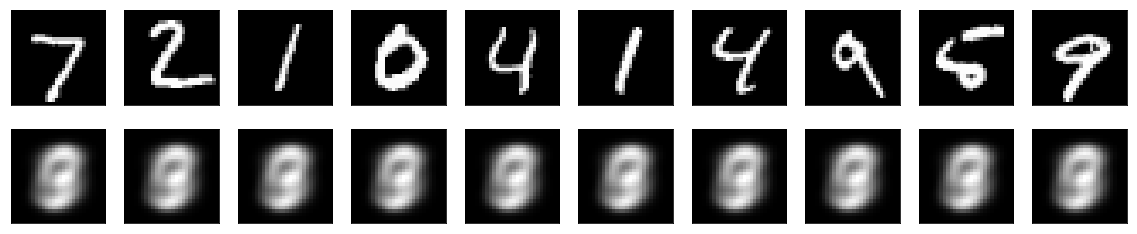

In [63]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [64]:
W = encoder.layers[-1].get_weights()[0]

In [65]:
W.shape

(784, 32)

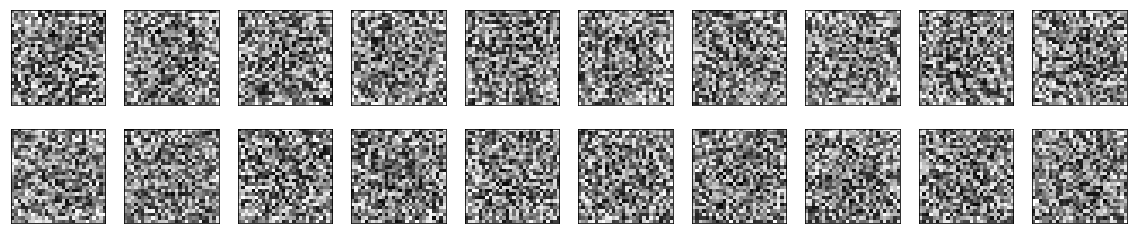

In [66]:
n = 10  # how many basis images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(W[:,i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(W[:,n+i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [36]:
np.min(W)

-0.110595524

### Deep autoencoder


In [83]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(32,))
decoded = Dense(64, activation='relu')(encoded_input)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
decoder = Model(encoded_input, decoded)

decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [84]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 9s 150us/step - loss: 0.3454 - val_loss: 0.2636
Epoch 2/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.2579 - val_loss: 0.2508
Epoch 3/100
60000/60000 [==============================] - 7s 122us/step - loss: 0.2429 - val_loss: 0.2364
Epoch 4/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.2301 - val_loss: 0.2240
Epoch 5/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.2213 - val_loss: 0.2161
Epoch 6/100
60000/60000 [==============================] - 8s 128us/step - loss: 0.2080 - val_loss: 0.2010
Epoch 7/100
60000/60000 [==============================] - 7s 123us/step - loss: 0.1990 - val_loss: 0.1939
Epoch 8/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.1899 - val_loss: 0.1856
Epoch 9/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.1822 - val_

In [85]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

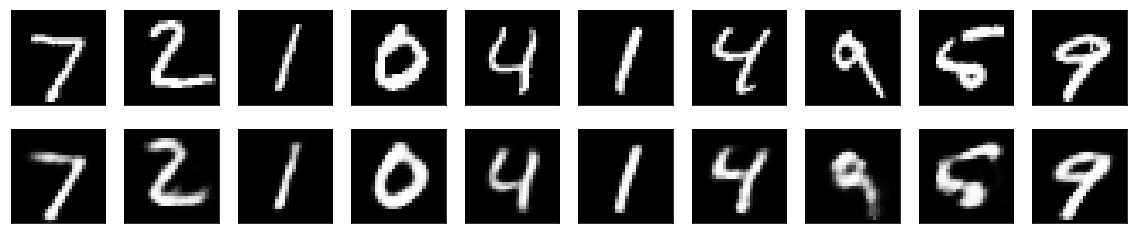

In [86]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [87]:
encoded_imgs.shape

(10000, 32)

In [88]:
decoded_imgs.shape

(10000, 784)

In [89]:
W = np.dot(np.linalg.pinv(encoded_imgs), decoded_imgs)

In [90]:
W.shape

(32, 784)

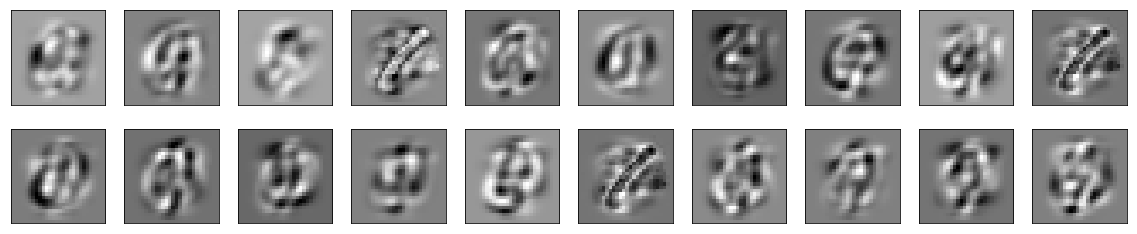

In [91]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(W[i,:].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(W[i+n,:].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder

In [92]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img, encoded)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
encoded_img = Input(shape=(4, 4, 8))  # adapt this if using `channels_first` image data format

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_img)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_img, decoded)

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [93]:
# reshaping the dataset now that we can work directly on images
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [94]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 89s 1ms/step - loss: 0.2142 - val_loss: 0.1626
Epoch 2/50
60000/60000 [==============================] - 91s 2ms/step - loss: 0.1527 - val_loss: 0.1455
Epoch 3/50
60000/60000 [==============================] - 96s 2ms/step - loss: 0.1397 - val_loss: 0.1332
Epoch 4/50
60000/60000 [==============================] - 94s 2ms/step - loss: 0.1321 - val_loss: 0.1279
Epoch 5/50
60000/60000 [==============================] - 87s 1ms/step - loss: 0.1269 - val_loss: 0.1236
Epoch 6/50
60000/60000 [==============================] - 85s 1ms/step - loss: 0.1231 - val_loss: 0.1221
Epoch 7/50
60000/60000 [==============================] - 88s 1ms/step - loss: 0.1206 - val_loss: 0.1181
Epoch 8/50
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1185 - val_loss: 0.1201
Epoch 9/50
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1168 - val_loss: 0.1122
Epoch

/home/bastien/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.317924). Check your callbacks.
  % delta_t_median)
/home/bastien/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159463). Check your callbacks.
  % delta_t_median)


60000/60000 [==============================] - 101s 2ms/step - loss: 0.1022 - val_loss: 0.1005
Epoch 35/50
60000/60000 [==============================] - 94s 2ms/step - loss: 0.1020 - val_loss: 0.1005
Epoch 36/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1018 - val_loss: 0.1006
Epoch 37/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1013 - val_loss: 0.0983
Epoch 38/50
60000/60000 [==============================] - 85s 1ms/step - loss: 0.1011 - val_loss: 0.0994
Epoch 39/50
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1011 - val_loss: 0.1018
Epoch 40/50
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1008 - val_loss: 0.0979
Epoch 41/50
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1006 - val_loss: 0.1004
Epoch 42/50
60000/60000 [==============================] - 87s 1ms/step - loss: 0.1005 - val_loss: 0.0990
Epoch 43/50
60000/60000 [==============================] 

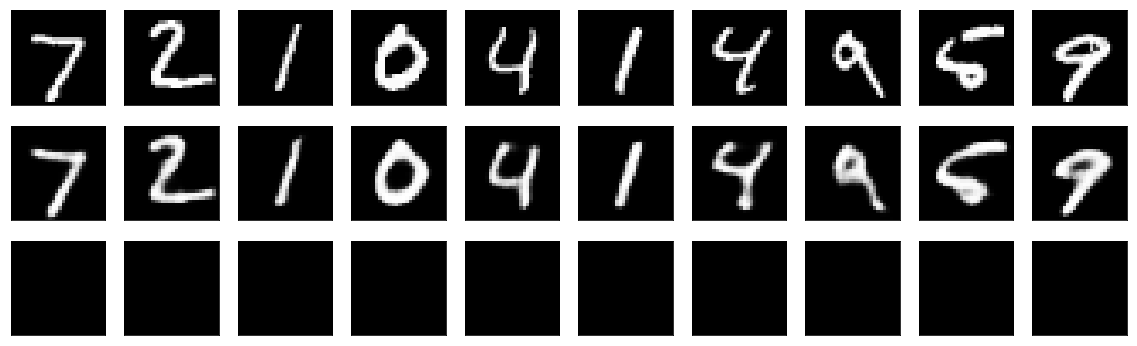

In [101]:
decoded_imgs = autoencoder.predict(x_test)
encoded_imgs = encoder.predict(x_test)
decoded_imgs2 = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction using encoder and decoder
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow((np.abs(decoded_imgs[i]-decoded_imgs2[i])).reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()

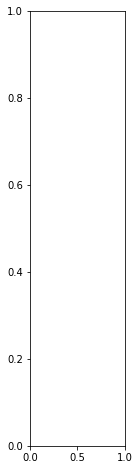

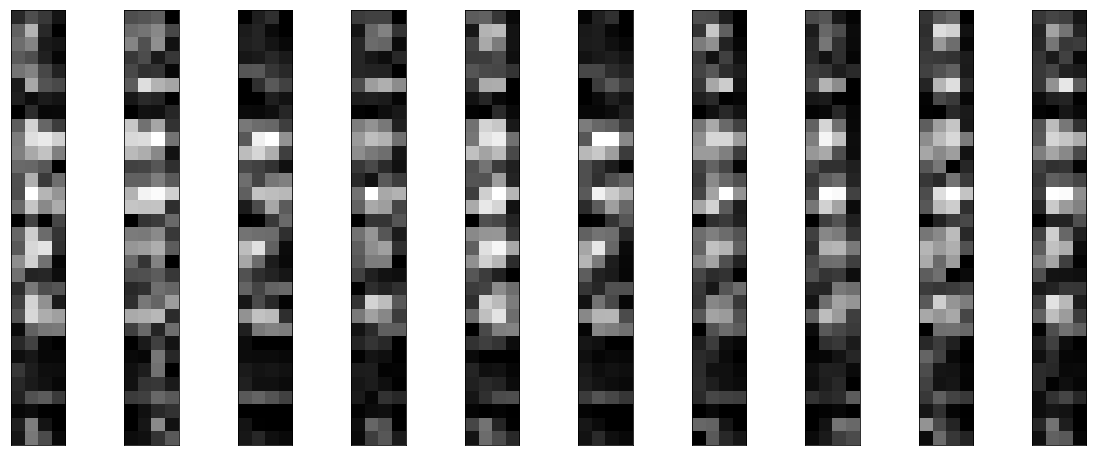

In [99]:
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [104]:
H = encoded_imgs.reshape((x_test.shape[0], 4*4*8))

In [105]:
H.shape

(10000, 128)

In [106]:
pinvH = np.linalg.pinv(H)

In [108]:
W = np.dot(pinvH, x_test.reshape((x_test.shape[0], 28*28)))

In [109]:
W.shape

(128, 784)

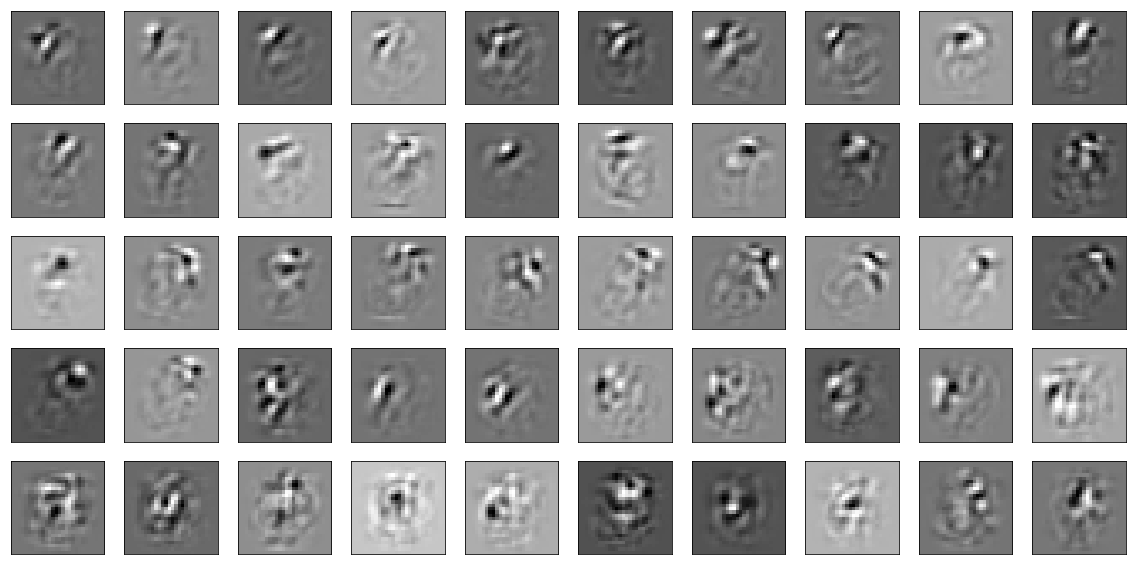

In [111]:
n = 50  # how many digits we will display
plt.figure(figsize=(20, 10))
for i in range(n):
    # display basis image
    ax = plt.subplot(5, 10, i + 1)
    plt.imshow(W[i,:].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Variational Autoencoders


In [4]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [51]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [52]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal_variable(shape=(batch_size, latent_dim),
                              mean=0., scale=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [53]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [54]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [55]:
def vae_loss(x, x_decoded_mean):
    xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [56]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 14s 227us/step - loss: 0.2973 - val_loss: 0.2631
Epoch 2/50
60000/60000 [==============================] - 14s 232us/step - loss: 0.2688 - val_loss: 0.2786
Epoch 3/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.3192 - val_loss: 0.3403
Epoch 4/50
60000/60000 [==============================] - 13s 208us/step - loss: 0.4435 - val_loss: 0.4103
Epoch 5/50
60000/60000 [==============================] - 12s 202us/step - loss: 0.6985 - val_loss: 0.5871
Epoch 6/50
60000/60000 [==============================] - 12s 196us/step - loss: 0.9554 - val_loss: 1.2218
Epoch 7/50
60000/60000 [==============================] - 12s 195us/step - loss: 1.2533 - val_loss: 2.7032
Epoch 8/50
60000/60000 [==============================] - 11s 176us/step - loss: 1.5946 - val_loss: 2.9740
Epoch 9/50
60000/60000 [==============================] - 11s 175us/step - loss: 2.0268 - val_

In [57]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_decoded = generator.predict(x_test_encoded, batch_size=batch_size)

In [58]:
x_test_decoded.shape

(10000, 784)

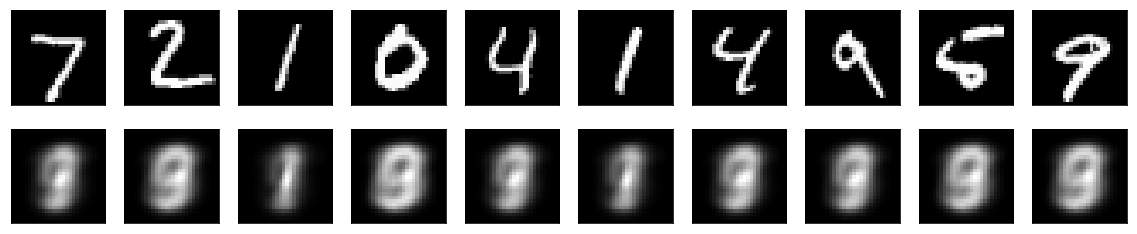

In [59]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

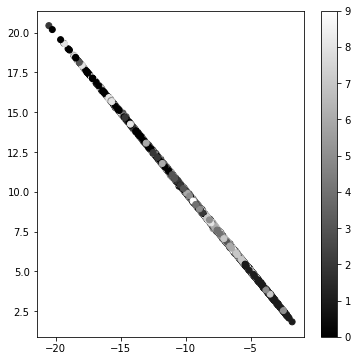

In [60]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

/home/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Output "dense_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_5" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

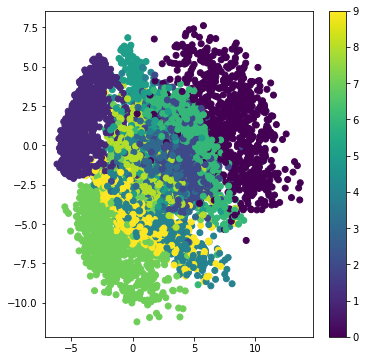

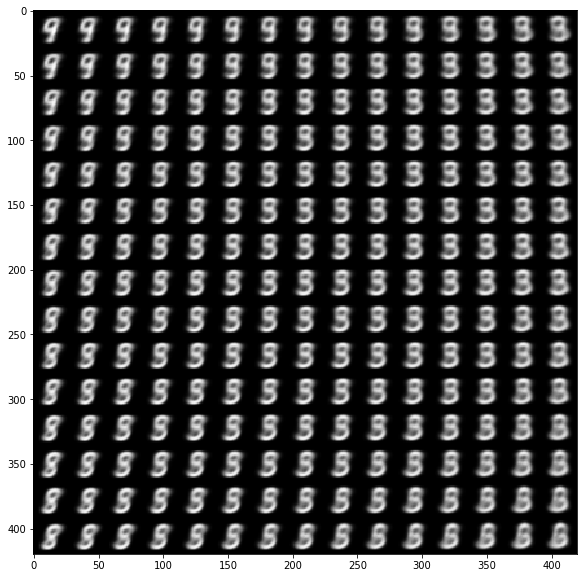

In [5]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

/home/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Output "dense_30" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_30" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 256)          200960      input_9[0][0]                    
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 2)            514         dense_26[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 2)            514         dense_26[0][0]                   
__________________________________________________________________________________________________
lambda_6 (

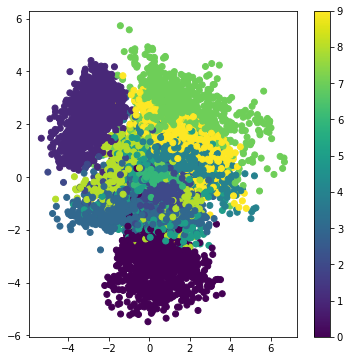

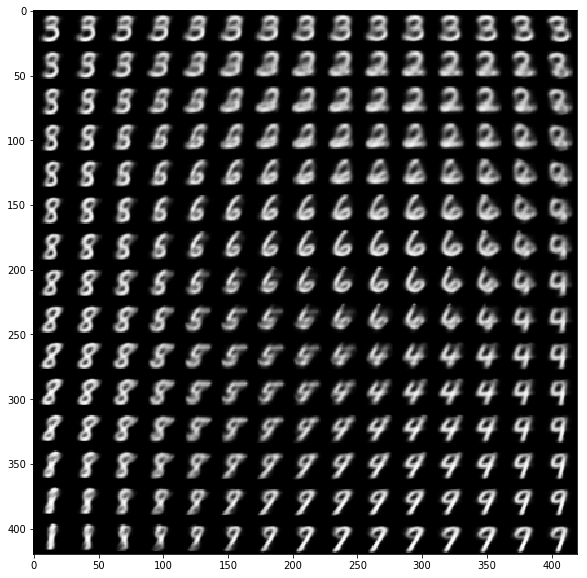

In [13]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 0.01


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * losses.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))



# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()



# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

/home/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Output "dense_40" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_40" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 256)          200960      input_13[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 2)            514         dense_36[0][0]                   
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 2)            514         dense_36[0][0]                   
__________________________________________________________________________________________________
lambda_8 (

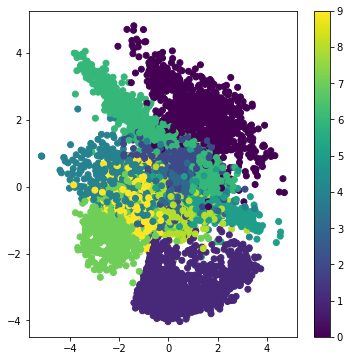

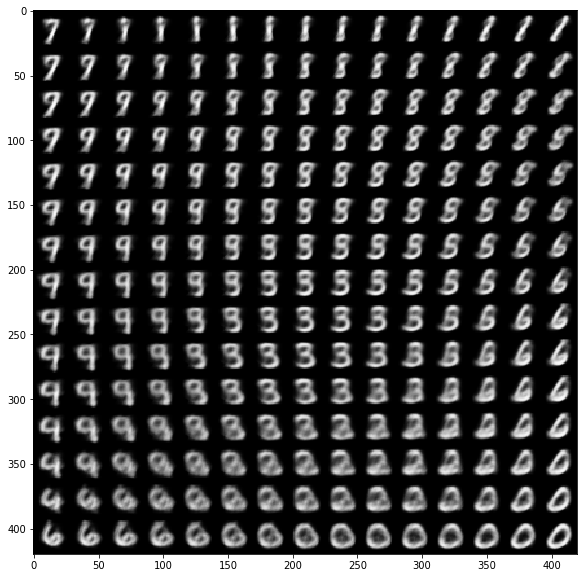

In [15]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 11
epsilon_std = 1


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * losses.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))



# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()



# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [11]:
import keras
keras.__version__

'2.1.6'

In [12]:
import tensorflow
tensorflow.__version__

'1.8.0'

### Fixing

In [41]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1

In [42]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [43]:
vae.losses

[]

In [44]:
# Compute VAE loss
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 256)          200960      input_21[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 2)            514         dense_56[0][0]                   
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 2)            514         dense_56[0][0]                   
__________________________________________________________________________________________________
lambda_12 

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 16s 259us/step - loss: 190.2530 - val_loss: 173.0951
Epoch 2/50
60000/60000 [==============================] - 14s 230us/step - loss: 171.7487 - val_loss: 170.1335
Epoch 3/50
60000/60000 [==============================] - 14s 241us/step - loss: 168.4986 - val_loss: 167.2158
Epoch 4/50
60000/60000 [==============================] - 15s 254us/step - loss: 166.3038 - val_loss: 165.5487
Epoch 5/50
60000/60000 [==============================] - 15s 245us/step - loss: 164.6201 - val_loss: 163.5309
Epoch 6/50
60000/60000 [==============================] - 14s 230us/step - loss: 163.3787 - val_loss: 162.6472
Epoch 7/50
60000/60000 [==============================] - 16s 271us/step - loss: 162.5838 - val_loss: 163.4751
Epoch 8/50
60000/60000 [==============================] - 16s 260us/step - loss: 162.1289 - val_loss: 161.8178
Epoch 9/50
60000/60000 [==============================] - 16s 

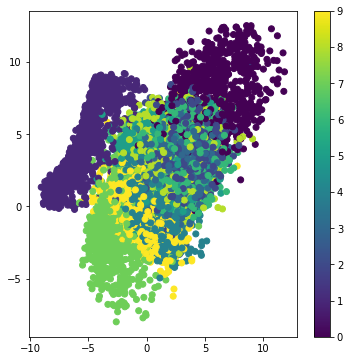

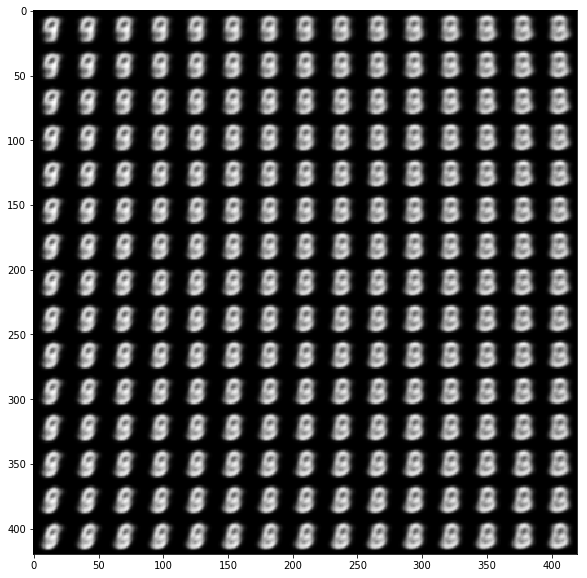

In [45]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x=x_train, y=x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))



# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()



# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### Test on GPUs

In [2]:
#!/usr/bin/python3

import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics, losses
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

t0 = time.clock()

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

t1 = time.clock()

print("Time: ", t1-t0)

autoencoder.save('./test.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.3556 - val_loss: 0.2710
Epoch 2/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.2640 - val_loss: 0.2533
Epoch 3/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.2423 - val_loss: 0.2290
Epoch 4/50
60000/60000 [==============================] - 5s 91us/step - loss: 0.2207 - val_loss: 0.2102
Epoch 5/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.2051 - val_loss: 0.1976
Epoch 6/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.1942 - val_loss: 0.1884
Epoch 7/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.1862 - val_loss: 0.1814
Epoch 8/50
60000/60000 [==============================] - 6s 101us/step - loss: 0.1800 - val_loss: 0.1758
Epoch 9/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.1747 - val_loss: 0.1709
